In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import theano.tensor as tt

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

/Users/paul.pop/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/paul.pop/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/Users/paul.pop/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import sys, os
sys.path.append(os.getcwd().split('notebooks')[0])
import utils

/Users/paul.pop/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [4]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_AMELIA_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')

In [5]:
df, labels = utils.process_amelia(DATA_AMELIA_FILE)
X_train, Y_train, X_test, Y_test = utils.get_train_test_data(df, regression=False, train_size=0.8)

# Pymc3

In [ ]:
_, num_X = X_train.shape

with pm.Model() as model:       
    intercept = pm.Normal('intercept', mu=0, sd=100)
    beta_gender = pm.Normal('beta_gender', mu=0, sd=100)
    beta_IK = pm.Normal('beta_IK', mu=0, sd=100)
    beta_age_surgery = pm.Normal('beta_age_surgery', mu=0, sd=100)
    mu = tt.exp(intercept 
                + beta_gender*df.Gender 
                + beta_IK*df.IK
                + beta_age_surgery*df.Age_surgery)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=df['life_expectancy'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

In [ ]:
_ = pm.traceplot(trace)

In [ ]:
_ = sns.pairplot(pm.trace_to_dataframe(trace[20000:]), plot_kws={'alpha':.5})

In [ ]:
trace['beta_age_surgery']

In [ ]:
# 'Gender', 'Tumor_grade', '', 'life_expectancy', 'IDH_TERT',
#        '', 'life_expectancy_bin', '', '',
#        '', '', 'Gene_Cdk4_NORMAL',
#        '', 'X1p19q_codel_1', 'IDH_NC', 'IDH_mutant', 'IDH_wt',
#        'TERT_mutant', 'TERT_wt', '', '',
#        '', '', '',
#        '', '', '',
#        'Tumor_Position_médian', 'Tumor_Position_non précisé',
#        '', '',
#        'Gene_Ihc_Atrx_Extinction diffuse', 'Gene_Ihc_Atrx_Maintien',
#        'Gene_Ihc_Atrx_extinction', 'Tumor_type_GBM', 'Tumor_type_astrocytome',
#        'Tumor_type_astrocytome gémistocytique (=A2)',
#        'Tumor_type_astrocytome pilocytique', 'Tumor_type_gangliogliome',
#        'Tumor_type_gliome', 'Tumor_type_oligo', '',
#        '', '', '',
#        'Gene_Mgmt_METHYLE', 'Gene_Mgmt_NON METHYLE', 'Surgery_type_aucune',
#        'Surgery_type_biopsie', 'Surgery_type_exérèse',
#        'Surgery_type_partielle', 'Gene_P53_ALTERE', 'Gene_P53_NC',
#        'Gene_P53_NORMAL', 'Gene_Ch10Q_NON PERTE', 'Gene_Ch10Q_PERTE'

### Functions

In [ ]:
#TODO
# def get_categorical_arg(df_data, column_name):
#     return pm.Categorical(name='beta_' + column_name, p=df_data[column_name].mean())

def get_binary_arg(df_data, column_name):
    return pm.Bernoulli(name='beta_' + column_name, p=df_data[column_name].mean())

def get_numerical_arg(df_data, column_name):
    return pm.Normal('beta_' + column_name, mu=df_data[column_name].mean(), sd=df_data[column_name].std())

In [ ]:
_, num_X = X_train.shape

with pm.Model() as model:       
    intercept = pm.Normal('intercept', mu=50, sd=100)
    mu = tt.exp(intercept 
                + get_binary_arg(df, 'Gender') * df.Gender  
                + get_binary_arg(df, 'Gene_Ch9P_GAIN') * df.Gene_Ch9P_GAIN  
                #+ get_binary_arg(df, 'Gene_Ch9P_NON PERTE') * df.Gene_Ch9P_  #Bine ca n-ai putut pune liniuta
#                 + get_binary_arg(df, 'Tumor_Location_A') * df.Tumor_Location_A  
#                 + get_binary_arg(df, 'Tumor_Location_B') * df.Tumor_Location_B  
#                 + get_binary_arg(df, 'Tumor_Location_C') * df.Tumor_Location_C  
#                 + get_binary_arg(df, 'Tumor_Position_D') * df.Tumor_Position_D  # De ce e position si nu location?
#                 + get_binary_arg(df, 'Tumor_Position_G') * df.Tumor_Position_G 
#                 + get_binary_arg(df, 'Tumor_Location_N') * df.Tumor_Location_N 
#                 + get_binary_arg(df, 'Tumor_Position_bilatéral') * df.Tumor_Position_bilatéral 
#                 + get_binary_arg(df, 'Gene_Mdm2_AMPLIFIE') * df.Gene_Mdm2_AMPLIFIE 
#                 + get_binary_arg(df, 'Gene_Mdm2_NORMAL') * df.Gene_Mdm2_NORMAL 
#                 + get_binary_arg(df, 'Gene_P16_DELETE') * df.Gene_P16_DELETE 
#                 + get_binary_arg(df, 'Gene_P16_NORMAL') * df.Gene_P16_NORMAL 
#                 + get_binary_arg(df, 'Gene_Egfr_AMPLIFIE') * df.Gene_Egfr_AMPLIFIE 
#                 + get_binary_arg(df, 'Gene_Egfr_NORMAL') * df.Gene_Egfr_NORMAL 
#                 + get_binary_arg(df, 'Gene_Cdk4_AMPLIFIE') * df.Gene_Cdk4_AMPLIFIE 
#                 + get_binary_arg(df, 'Gene_Ch9P_PERTE') * df.Gene_Ch9P_PERTE 
                + get_binary_arg(df, 'X1p19q_codel_0') * df.X1p19q_codel_0 
                + get_binary_arg(df, 'Tumor_Location_autre') * df.Tumor_Location_autre 
                + get_numerical_arg(df, 'IK') * df.IK
                + get_numerical_arg(df, 'Age_surgery') * df.Age_surgery
               )
    
    y_est = pm.Poisson('y_est', mu=mu, observed=df['life_expectancy'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

In [ ]:
_ = pm.traceplot(trace)

# Compute posterior 

In [10]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return stats.norm(mu_post, np.sqrt(sigma_post)).pdf(x)

def plot_posterior(data, column):
    ax = plt.subplot()
    x = np.linspace(-1, 1, 500)
    posterior_analytical = calc_posterior_analytical(data[column], x, 0., 1.)
    ax.plot(x, posterior_analytical)
    ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior {}'.format(column));
    sns.despine()
    plt.show()

In [ ]:
for col in df.columns:
    plot_posterior(df, col)

# Sampler 

In [ ]:
# Tried my own sampler

# def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1., sd_init=1.):
#     mu_current = mu_init
#     posterior = [mu_current]
#     for i in range(samples):
#         # suggest new position
#         mu_proposal = stats.norm(mu_current, proposal_width).rvs()
#         print(mu_proposal)

#         # Compute likelihood by multiplying probabilities of each data point
#         current = stats.norm(mu_current, sd_init).pdf(data)
#         proposal = stats.norm(mu_proposal, sd_init).pdf(data)
#         likelihood_current = current[current.nonzero()].prod()
#         likelihood_proposal = proposal[proposal.nonzero()].prod()
#         print(likelihood_current)
#         print(likelihood_proposal)
#         print('----')
#         # Compute prior probability of current and proposed mu        
#         prior_current = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
#         prior_proposal = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
#         p_current = likelihood_current * prior_current
#         p_proposal = likelihood_proposal * prior_proposal
        
#         # Accept proposal?
#         p_accept = p_proposal / p_current
        
#         # Usually would include prior probability, which we neglect here for simplicity
#         accept = np.random.rand() < p_accept
        
#         if plot or i == samples - 1:
#             plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
#         if accept:
#             # Update position
#             mu_current = mu_proposal
            
#         posterior.append(mu_current)
        
#     return posterior

# # Function to display
# def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
#     from copy import copy
#     trace = copy(trace)
#     fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
#     fig.suptitle('Iteration %i' % (i + 1))
#     x = np.linspace(-3, 3, 5000)
#     color = 'g' if accepted else 'r'
        
#     # Plot prior
#     prior_current = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
#     prior_proposal = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
#     prior = stats.norm(mu_prior_mu, mu_prior_sd).pdf(x)
#     ax1.plot(x, prior)
#     ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
#     ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
#     ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
#                  arrowprops=dict(arrowstyle="->", lw=2.))
#     ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
#     # Likelihood
#     likelihood_current = stats.norm(mu_current, 1).pdf(data).prod()
#     likelihood_proposal = stats.norm(mu_proposal, 1).pdf(data).prod()
#     y = stats.norm(loc=mu_proposal, scale=1).pdf(x)
#     sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
#     ax2.plot(x, y, color=color)
#     ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
#     ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
#     #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
#     ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
#                  arrowprops=dict(arrowstyle="->", lw=2.))
#     ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
#     # Posterior
#     posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
#     ax3.plot(x, posterior_analytical)
#     posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
#     posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
#     ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
#     ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
#     ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
#                  arrowprops=dict(arrowstyle="->", lw=2.))
#     #x3.set(title=r'prior x likelihood $\propto$ posterior')
#     ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
#     if accepted:
#         trace.append(mu_proposal)
#     else:
#         trace.append(mu_current)
#     ax4.plot(trace)
#     ax4.set(xlabel='iteration', ylabel='mu', title='trace')
#     plt.tight_layout()
#     #plt.legend()

In [ ]:
# Pymc Sampler
def sampler(data, column, plot=False, samples=15000):
    with pm.Model():
        mu = pm.Normal('mu', 0, 1)
        sigma = 1.
        returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data[column])

        step = pm.Metropolis()
        trace = pm.sample(samples, step)
        
    if plot:
        sns.distplot(posterior['mu'], label=column);
        plt.legend();
        
        fig, ax = plt.subplots()
        ax.plot(posterior)
        _ = ax.set(xlabel='sample', ylabel='mu', title=column);
    return trace

In [ ]:
col = 'Age_surgery'
posterior = sampler(df, col, plot=True)

In [ ]:
col = 'Tumor_grade'
posterior = sampler(df, col, plot=True)

In [ ]:
plt.hist(df['Tumor_grade'].values)

In [ ]:
col = 'life_expectancy'
posterior = sampler(df, col, plot=True)

In [ ]:
# GLM

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pymc import  *
import pandas as pd
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.tools.plotting import scatter_matrix

In [8]:
df.head()

,Gender,Tumor_grade,Age_surgery,life_expectancy,IDH_TERT,IK,life_expectancy_bin,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,...,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,IDH_NC,IDH_mutant,IDH_wt
0,1,3,42,30,3,90.512838,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
1,1,2,28,2069,2,90.596534,2,0,0,1,...,0,0,1,0,0,1,0,1,0,0
2,0,4,59,393,4,70.000000,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
3,1,4,61,398,3,60.000000,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1
4,0,4,58,433,4,70.000000,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1


In [9]:
with pm.Model():
    pm.GLM.from_formula('life_expectancy ~ IK + Age_surgery', df, family=pm.families.Binomial())
    trace = pm.sample(1000, pm.Slice(), progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [Age_surgery]
>Slice: [IK]
>Slice: [Intercept]
INFO (theano.gof.compilelock): Waiting for existing lock by process '1683' (I am process '1684')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '1683' (I am process '1685')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '1684' (I am process '1685')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir


KeyboardInterrupt: 

In [ ]:
plt.subplot(111, xlabel='x', ylabel='y', 
            title='Posterior predictive regression lines')
plt.plot(x_out, y_out, 'x', label='data')
pm.plots.plot_posterior_predictive_glm(trace, samples=100, 
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')

plt.legend(loc=0);

In [ ]:
trace_df = trace_to_dataframe(trace)
scatter_matrix(trace_df, figsize=(8, 8));

In [20]:
with pm.Model():
    pm.GLM.from_formula('life_expectancy ~ IK + Age_surgery', df)
    trace = pm.sample(100, pm.Slice(), progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sd_log__]
>Slice: [Age_surgery]
>Slice: [IK]
>Slice: [Intercept]
  0%|          | 0/600 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats, optimize
from sklearn.datasets import load_diabetes
from sklearn.cross_validation import train_test_split
from theano import shared

np.random.seed(9)

%matplotlib inline

WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmp2mtcrmo0/me2e380d53316895e71d165d7dbdae09a4f633147fc97edcb5ad823c3ba58ee08.so... this could lead to problems.
WARNING (theano.gof.cmodule): Removing key file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmp2mtcrmo0/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmp0m10ygo5/m2bc19d64bc62a026741782b1e76b7d41695cc063c8a46ffd1976e0da65b16f0b.so... this could lead to problems.
WARNING (theano.gof.cmodule): Removing key file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmp0m10ygo5/key.pkl because the corresponding module is g

WARNING (theano.gof.cmodule): Removing key file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmp5zr8cqjd/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmp69lkztlq/m8803b6ef43f1225e8f3ef7e5b36fe471e59c5c3d87c1d23f80ec967ea42dc0f4.so... this could lead to problems.
WARNING (theano.gof.cmodule): Removing key file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmp69lkztlq/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmpgrs9puw1/m8585e9685fb5a155c2dd865196244bf38abbc2daede7c2bb0382fafd606902a2.so... thi

WARNING (theano.gof.cmodule): Removing key file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmplqcqzucy/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmpk0gtfnj0/m70542f94d0fa8294932bfe3e6e97b004f11825a71aac6bc9c5e16db40f088ccd.so... this could lead to problems.
WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmps46k6ibm/m75ca2464ce7fc88fd9bc06164189b306d1613c90ef261cfde92350be3475c7e3.so... this could lead to problems.
WARNING (theano.gof.cmodule): Removing key file /Users/paul.pop/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.3-64/tmps46k6ibm/key.pkl because the corresponding module is g

Optimization terminated successfully.
         Current function value: 3015.408808
         Iterations: 4
         Function evaluations: 485


logp = -3,015.4:  10%|▉         | 485/5000 [00:00<00:07, 607.79it/s] 
/Users/paul.pop/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, betas, alpha]
100%|██████████| 1500/1500 [00:13<00:00, 113.23it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1323fb470>,
      dtype=object)

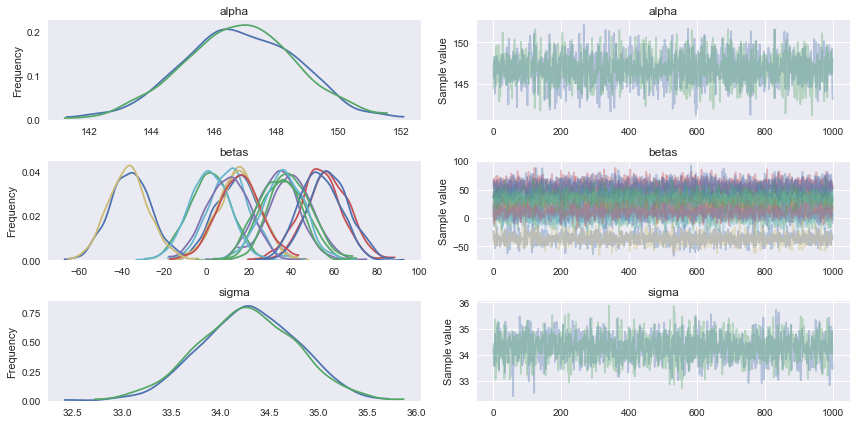

In [11]:
#Load the Data
#diabetes_data = load_diabetes()
#X, y_ = diabetes_data.data, diabetes_data.target

#Split Data
X_tr = X_train_r
X_te = X_test_r
y_tr = Y_train_r
y_te = Y_test_r

#Shapes
X.shape, y_.shape, X_tr.shape, X_te.shape
#((442, 10), (442,), (331, 10), (111, 10))

#Preprocess data for Modeling
shA_X = shared(X_tr)

#Generate Model
linear_model = pm.Model()

with linear_model: 
    # Priors for unknown model parameters    
    alpha = pm.Normal("alpha", mu=0,sd=10)
    betas = pm.Normal("betas", mu=0,#X_tr.mean(), 
                               sd=10, 
                               shape=X.shape[1])
    sigma = pm.HalfNormal("sigma", sd=1)

    # Expected value of outcome
    mu = alpha + np.array([betas[j]*shA_X[:,j] for j in range(X.shape[1])]).sum()

    # Likelihood (sampling distribution of observations)
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed=y_tr)

    # Obtain starting values via Maximum A Posteriori Estimate
    map_estimate = pm.find_MAP(model=linear_model, fmin=optimize.fmin_powell)

    # Instantiate Sampler
    step = pm.NUTS(scaling=map_estimate)

    # MCMC
    trace = pm.sample(1000, step, start=map_estimate, progressbar=True, njobs=1)


#Traceplot
pm.traceplot(trace)

In [12]:
X

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

In [13]:
shA_X.set_value(X_te)
ppc = pm.sample_ppc(trace, model=linear_model, samples=1000)

100%|██████████| 1000/1000 [00:03<00:00, 321.15it/s]


In [20]:
len(ppc['likelihood'][110])

111

/Users/paul.pop/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, betas, alpha]
100%|██████████| 1500/1500 [00:14<00:00, 106.79it/s]


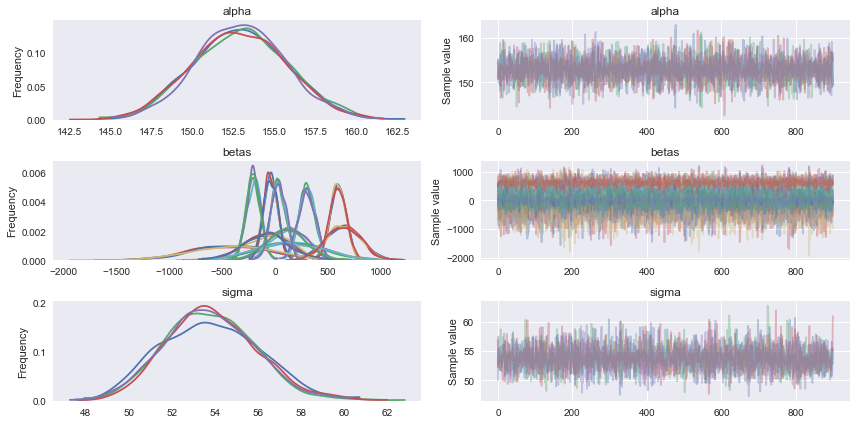

In [24]:
#Generate Model
linear_model = pm.Model()

with linear_model: 
    # Priors for unknown model parameters    
    alpha = pm.Normal("alpha", mu=y_tr.mean(),sd=10)
    betas = pm.Normal("betas", mu=0, sd=1000, shape=X.shape[1])
    sigma = pm.HalfNormal("sigma", sd=100) # you could also try with a HalfCauchy that has longer/fatter tails
    mu = alpha + pm.math.dot(betas, X_tr.T)
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed=y_tr)
    step = pm.NUTS()
    trace = pm.sample(1000, step)

chain = trace[100:]
pm.traceplot(chain);

/Users/paul.pop/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2401: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


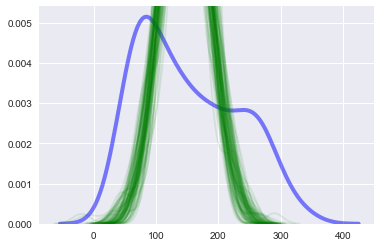

In [25]:
sns.kdeplot(y_tr, alpha=0.5, lw=4, c='b')
for i in range(100):
    sns.kdeplot(ppc['likelihood'][i], alpha=0.1, c='g')